In [1]:
import requests
import os

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
from matplotlib import cm

# Load Dataset for Portsmouth

#### You can either create this dataset running the notebook ./EnvDigitalTwin/AirQualityDatasetCreation, or download it from the data directory

In [6]:
env_data_dr = "./EnvDigitalTwin/data/"

In [7]:
df_port = pd.read_csv(env_data_dr+"/UKAIRAirQuality_digitaltwin_1h.csv", low_memory=False)

In [8]:
df_port.head()

,Unnamed: 0,Date,time,PM10 particulate matter (Hourly measured),status,unit,Nitric oxide,status.1,unit.1,Nitrogen dioxide,...,unit.8,Volatile PM2.5 (Hourly measured),status.9,unit.9,PM<sub>10</sub> particulate matter (Hourly measured),Non-volatile PM<sub>10</sub> (Hourly measured),Non-volatile PM<sub>2.5</sub> (Hourly measured),PM<sub>2.5</sub> particulate matter (Hourly measured),Volatile PM<sub>10</sub> (Hourly measured),Volatile PM<sub>2.5</sub> (Hourly measured)
0,0,01-01-2001,01:00,31.0,R,ugm-3 (GRAV EQ),1.0,R,ugm-3,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,01-01-2001,02:00,25.0,R,ugm-3 (GRAV EQ),0.0,R,ugm-3,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,01-01-2001,03:00,25.0,R,ugm-3 (GRAV EQ),0.0,R,ugm-3,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,01-01-2001,04:00,22.0,R,ugm-3 (GRAV EQ),0.0,R,ugm-3,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,01-01-2001,05:00,29.0,R,ugm-3 (GRAV EQ),0.0,R,ugm-3,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dataset exploration

In [9]:
serch_for = ["Date", "time", "status", "unit", "unnamed"]


chemicals = df_port.columns[df_port.columns.str.contains('|'.join(serch_for), case=False)==False]


In [10]:
serch_for = ["status", "unit"]


columns_to_keep = df_port.columns[df_port.columns.str.contains('|'.join(serch_for), case=True)==False]


In [11]:
df_port = df_port[columns_to_keep].copy()

## Studying the NaNs in the Dataset

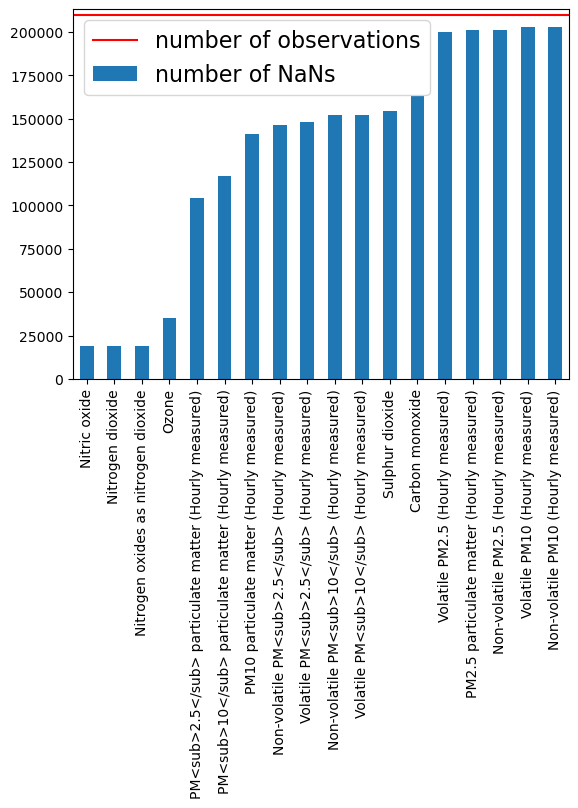

In [12]:
missing = df_port[chemicals].isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
f, ax = plt.subplots()


missing.plot.bar(label="number of NaNs");
plt.axhline(y=df_port[chemicals].shape[0], color="red", label="number of observations")
plt.legend(fontsize=16)
plt.show()

We can see how certain pollutants are observed more than others. We now want to see the distributions of pollutants with time.

In [13]:
def plot_chemicalsintime(df, chemicals_columns):
    colors = cm.rainbow(np.linspace(0, 1, len(chemicals_columns)))

    fig, axes = plt.subplots(nrows=len(chemicals_columns),ncols=1, sharex=True, figsize=(8,8))

    for i in range(len(chemicals_columns)):
        axes[i].plot(df["Date"], df[chemicals_columns[i]].astype(float), label=str(chemicals_columns[i]),\
                    color=colors[i])
        xmin, xmax = axes[i].get_xlim()
        N=10
        axes[i].set_xticks(np.round(np.linspace(xmin, xmax, N)))


        axes[i].xaxis.set_tick_params(rotation=45)
    fig.legend(bbox_to_anchor=(1.5, .75))
    plt.xlabel("time")


    plt.show()



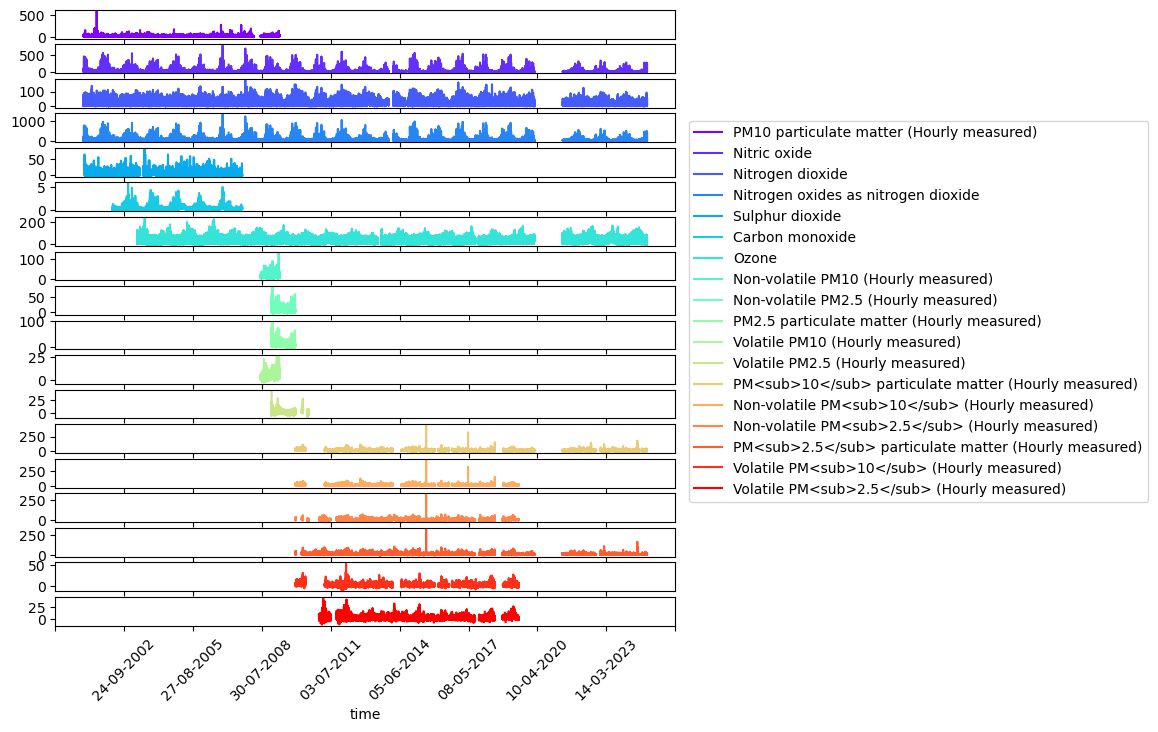

In [14]:
plot_chemicalsintime(df_port, df_port[chemicals].columns)

What we notice is that we have Carbon monoxide and Sulphur dioxide collected only up to 2007. 
We can use the other pollutants collected after 2007, and their relation with them, to forcast them. 

# Let's look if we have correlations amongst pollutants


In [15]:
import seaborn as sns


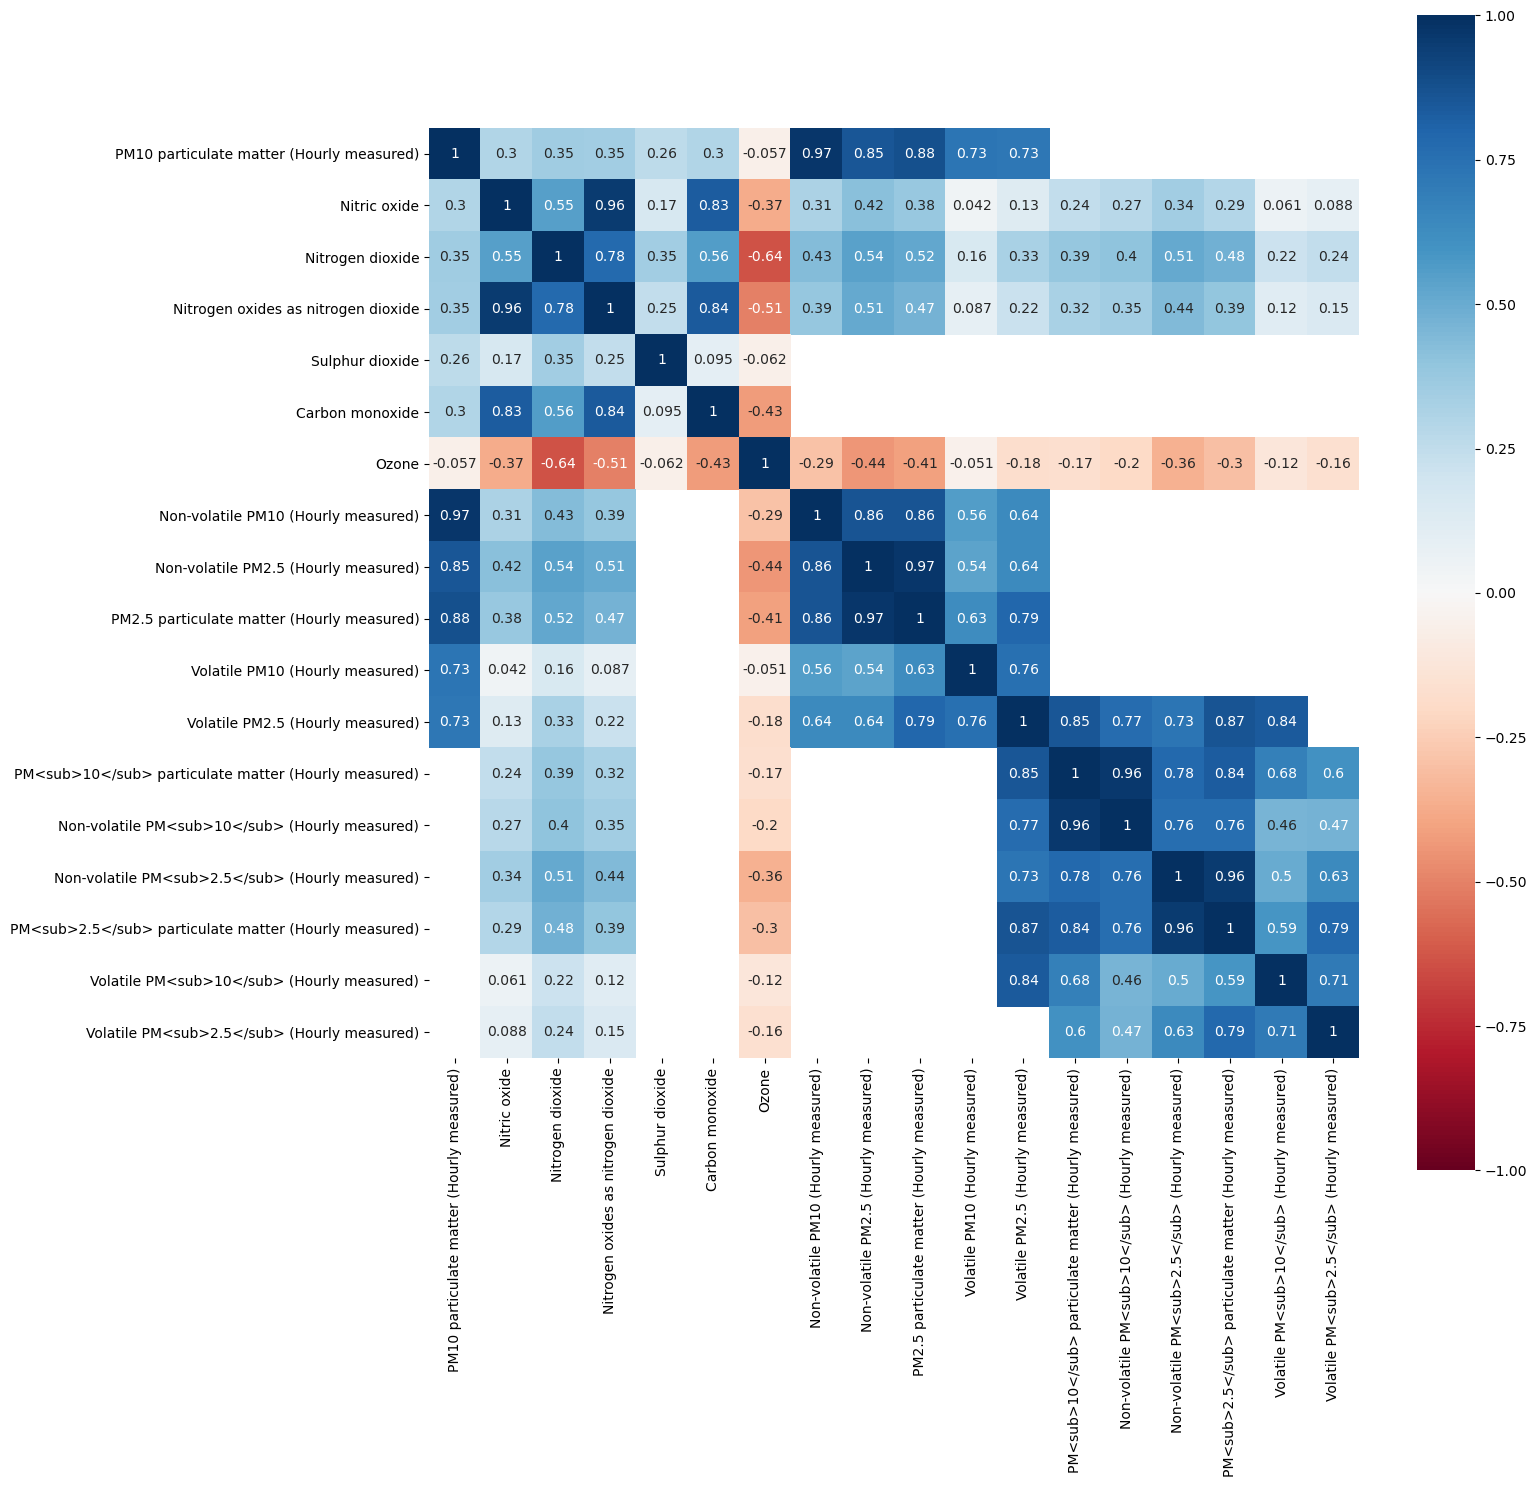

In [16]:
corrmat = df_port[chemicals].astype(float).corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots( figsize=(15, 15))
fig = sns.heatmap(corrmat, vmax=1, square=True, cmap="RdBu",  annot=True, vmin=-1);

plt.show()

### First results:
For Portsmouth, in particular in the context of Seachange, we are interest in the Sulphure Dioxide values since this chemical is linked to harbour pollution more than others.
Let's keep the most frequent chemicals to forcast the Sulphur dioxide and Carbon monoxide

In [17]:
df_port[chemicals].isnull().sum().sort_values()

Nitric oxide                                              18998
Nitrogen dioxide                                          18999
Nitrogen oxides as nitrogen dioxide                       19012
Ozone                                                     34952
PM<sub>2.5</sub> particulate matter (Hourly measured)    104289
PM<sub>10</sub> particulate matter (Hourly measured)     116987
PM10 particulate matter (Hourly measured)                141373
Non-volatile PM<sub>2.5</sub> (Hourly measured)          146395
Volatile PM<sub>2.5</sub> (Hourly measured)              147820
Non-volatile PM<sub>10</sub> (Hourly measured)           151851
Volatile PM<sub>10</sub> (Hourly measured)               151857
Sulphur dioxide                                          154685
Carbon monoxide                                          162832
Volatile PM2.5 (Hourly measured)                         199935
PM2.5 particulate matter (Hourly measured)               201359
Non-volatile PM2.5 (Hourly measured)    

In [18]:
np.concatenate([df_port[chemicals].isnull().sum().sort_values()[0:4].index, ["Sulphur dioxide", "carbon monoxide"]])

array(['Nitric oxide', 'Nitrogen dioxide',
       'Nitrogen oxides as nitrogen dioxide', 'Ozone', 'Sulphur dioxide',
       'carbon monoxide'], dtype=object)

In [19]:
corr_chemicals = np.concatenate([df_port[chemicals].isnull().sum().sort_values()[0:4].index, ["Sulphur dioxide", "Carbon monoxide"]])

In [20]:
columns_to_drop = list(set(chemicals).difference(corr_chemicals))

In [21]:
columns_to_drop

['Non-volatile PM<sub>10</sub> (Hourly measured)',
 'Volatile PM<sub>2.5</sub> (Hourly measured)',
 'Volatile PM10 (Hourly measured)',
 'Non-volatile PM<sub>2.5</sub> (Hourly measured)',
 'Non-volatile PM10 (Hourly measured)',
 'Volatile PM2.5 (Hourly measured)',
 'PM10 particulate matter (Hourly measured)',
 'PM2.5 particulate matter (Hourly measured)',
 'PM<sub>10</sub> particulate matter (Hourly measured)',
 'PM<sub>2.5</sub> particulate matter (Hourly measured)',
 'Non-volatile PM2.5 (Hourly measured)',
 'Volatile PM<sub>10</sub> (Hourly measured)']

In [22]:
df_port = df_port.drop(columns=columns_to_drop)

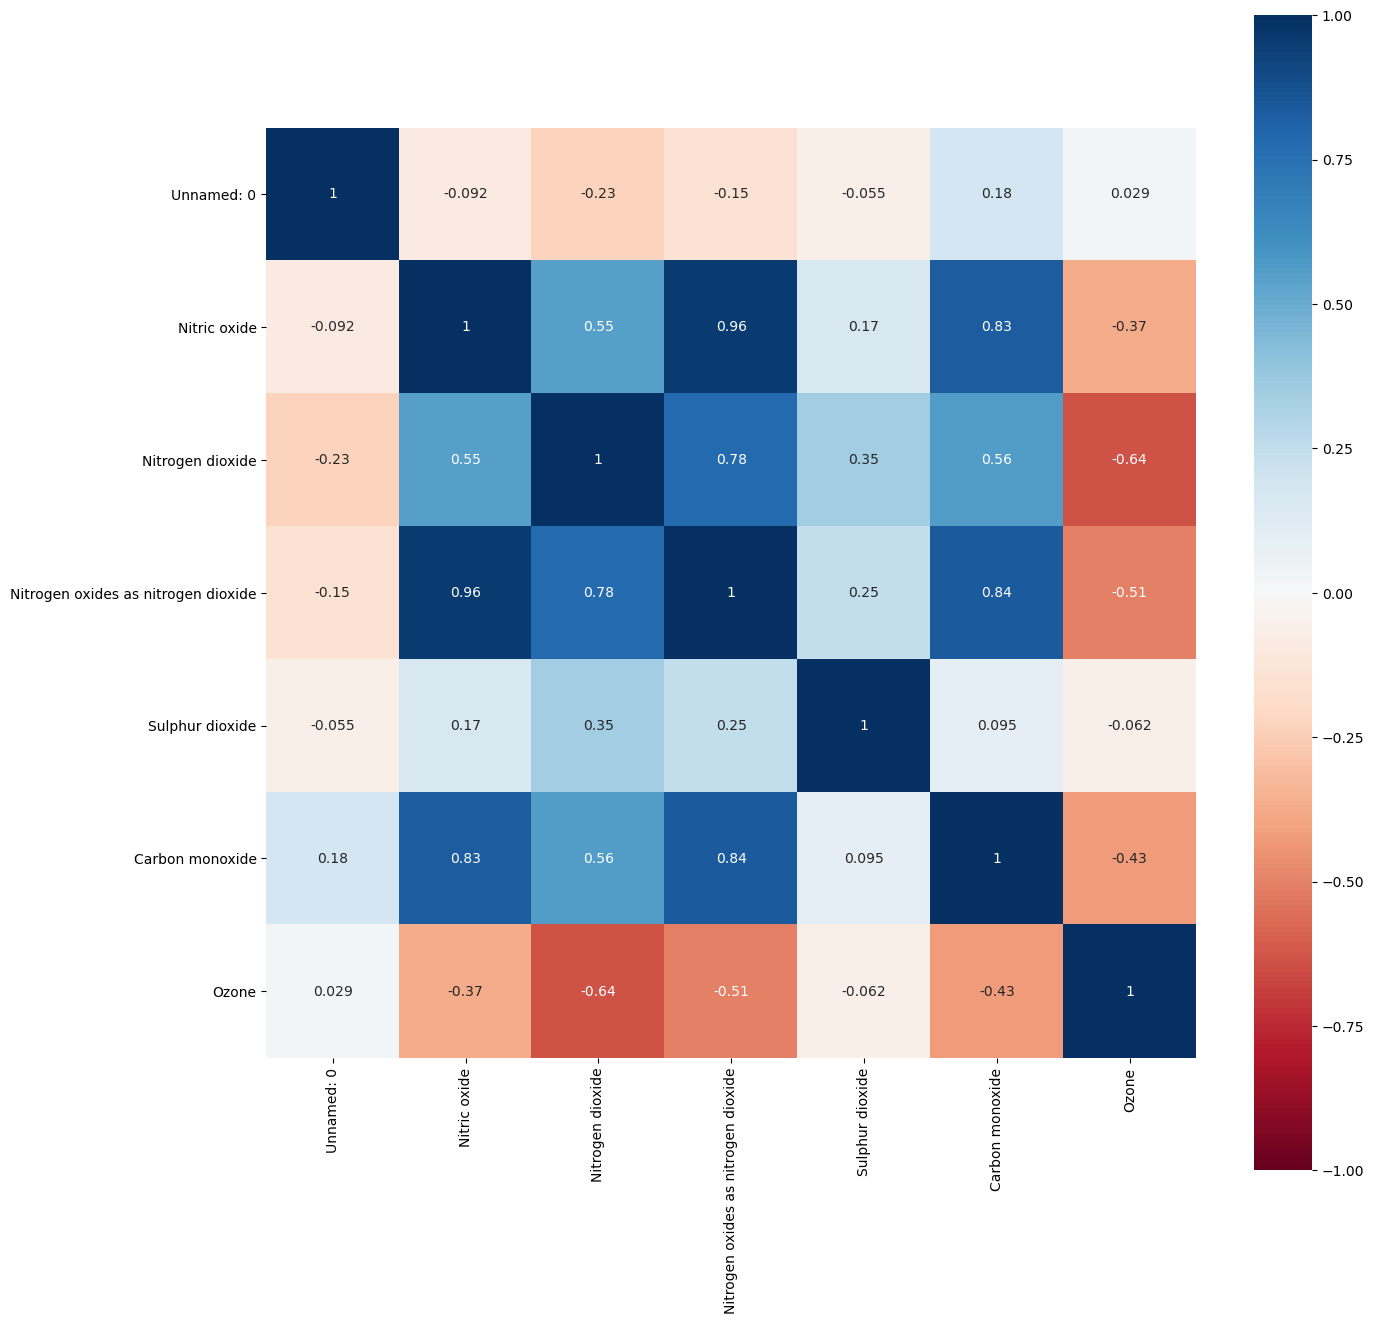

In [23]:
corrmat = df_port.drop(columns=["Date", "time"]).astype(float).corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots( figsize=(15, 15))
fig = sns.heatmap(corrmat, vmax=1, square=True, cmap="RdBu",  annot=True, vmin=-1);

plt.show()

In [24]:
df_port.head()

,Unnamed: 0,Date,time,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,Ozone
0,0,01-01-2001,01:00,1.0,6.0,8.0,NaN,NaN,NaN
1,1,01-01-2001,02:00,0.0,8.0,8.0,NaN,NaN,NaN
2,2,01-01-2001,03:00,0.0,6.0,6.0,NaN,NaN,NaN
3,3,01-01-2001,04:00,0.0,6.0,6.0,NaN,NaN,NaN
4,4,01-01-2001,05:00,0.0,6.0,6.0,NaN,NaN,NaN


#### Add time features

In [25]:
df_port['Date'] = pd.to_datetime(df_port['Date'], format='%d-%m-%Y') # Format for 'DD-MM-YYYY' # Step 3: Increment the date by 1 where the time was '00:00' (previously '24:00') mask = combined_df['Time'] == '00:00' combined_df.loc[mask, 'Date'] = combined_df['Date'] + pd.Timedelta(days=1) # Step 4: Combine the 'Date' and 'Time' columns into a single DateTime column combined_df['DateTime'] = pd.to_datetime(combined_df['Date'].astype(str) + ' ' + combined_df['Time']) # Step 5: Set 'DateTime' as the index (optional) combined_df.set_index('DateTime', inplace=True) # Step 6: Group by the date part and calculate the median for each day daily_median = combined_df.groupby(combined_df.index.date).median() # 

In [26]:
df_port['time'] = df_port['time'].replace('24:00', '00:00') # this is the format expected in pandas
mask = np.where(df_port['time'] == '00:00')


In [27]:
df_port['Date'].loc[mask] = pd.to_datetime(df_port['Date']) + pd.Timedelta(days=1) 

/home/nannil/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [28]:
df_port['seconds'] = pd.to_datetime(df_port['Date'].astype(str) + ' ' + df_port['time'])\
- pd.to_datetime(df_port['Date'].astype(str) + ' ' + df_port['time']).iloc[0]
df_port['seconds'] = df_port['seconds'].dt.total_seconds()*10**-8

## Month and day trigonometry
#### Adding these time features means, for example, defining January closer to December than to March, as opposite than just using the month as a number between 1 to 12

In [29]:
# Calculating cyclical features for month
df_port.loc[:, 'sine_month'] = np.sin(2 * np.pi * pd.to_datetime(df_port["Date"]).dt.month / 12)
df_port.loc[:, 'cosine_month'] = np.cos(2 * np.pi * pd.to_datetime(df_port["Date"]).dt.month / 12)

# Calculating cyclical features for day (assuming a maximum of 31 days)
df_port.loc[:, 'sine_day'] = np.sin(2 * np.pi * pd.to_datetime(df_port["Date"]).dt.day / 31)
df_port.loc[:, 'cosine_day'] = np.cos(2 * np.pi * pd.to_datetime(df_port["Date"]).dt.day / 31)

In [30]:
df_port.head()

,Unnamed: 0,Date,time,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,Ozone,seconds,sine_month,cosine_month,sine_day,cosine_day
0,0,2001-01-01,01:00,1.0,6.0,8.0,NaN,NaN,NaN,0.000000,0.5,0.866025,0.201299,0.97953
1,1,2001-01-01,02:00,0.0,8.0,8.0,NaN,NaN,NaN,0.000036,0.5,0.866025,0.201299,0.97953
2,2,2001-01-01,03:00,0.0,6.0,6.0,NaN,NaN,NaN,0.000072,0.5,0.866025,0.201299,0.97953
3,3,2001-01-01,04:00,0.0,6.0,6.0,NaN,NaN,NaN,0.000108,0.5,0.866025,0.201299,0.97953
4,4,2001-01-01,05:00,0.0,6.0,6.0,NaN,NaN,NaN,0.000144,0.5,0.866025,0.201299,0.97953


### Let's look at the distributions 

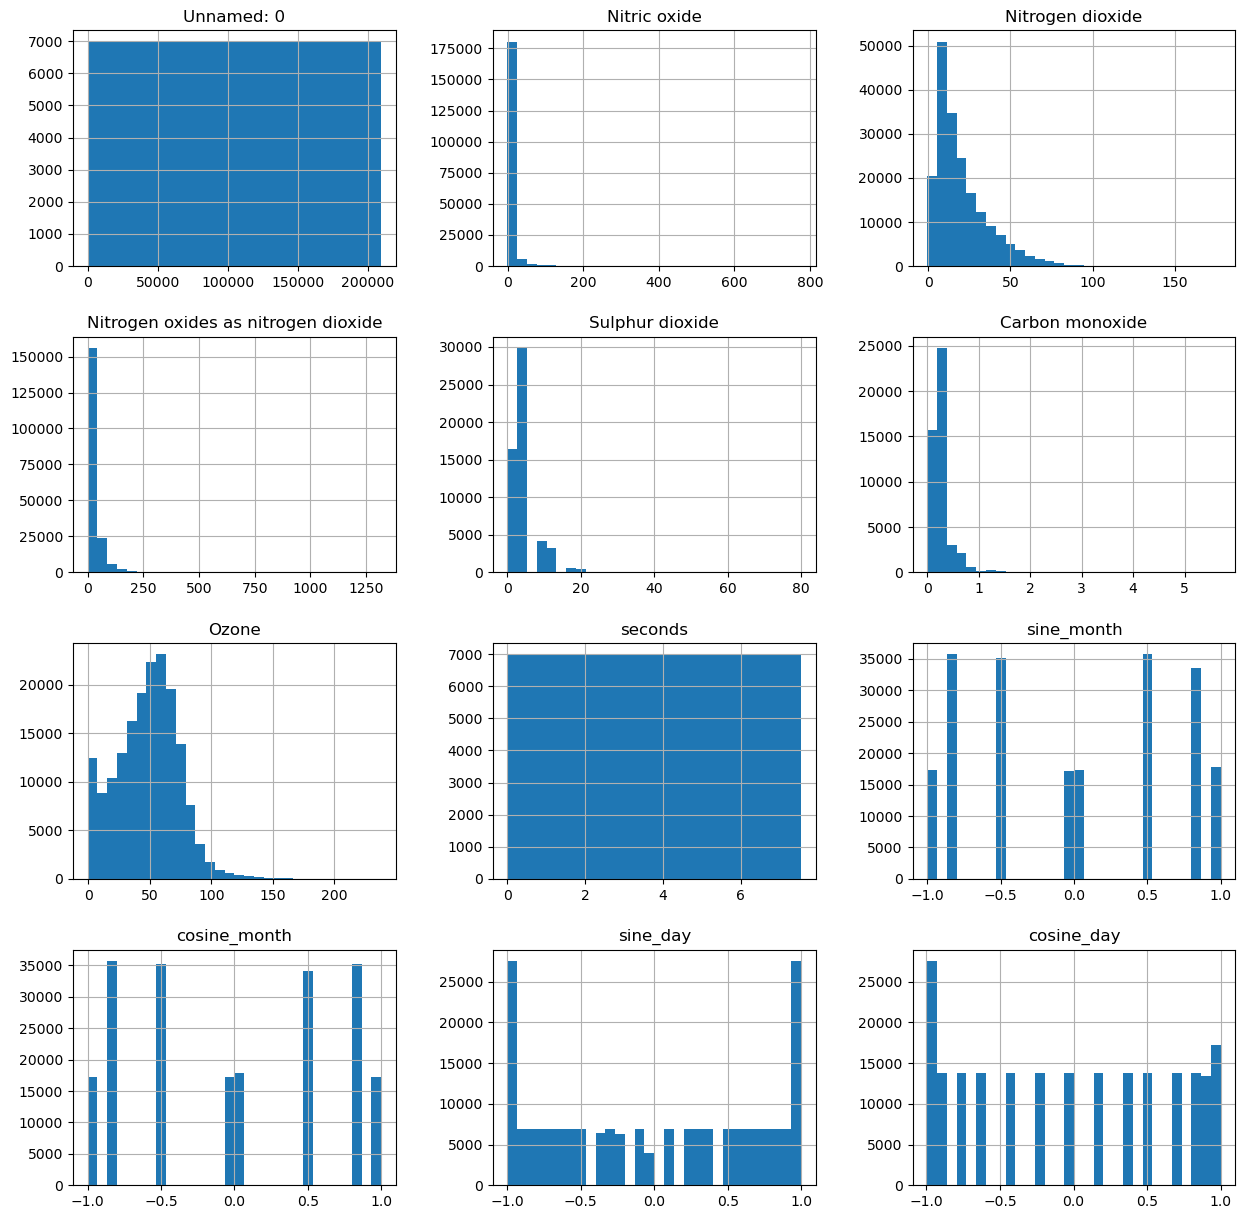

In [31]:
df_port.hist(bins=30,  figsize=(15, 15))
plt.show()

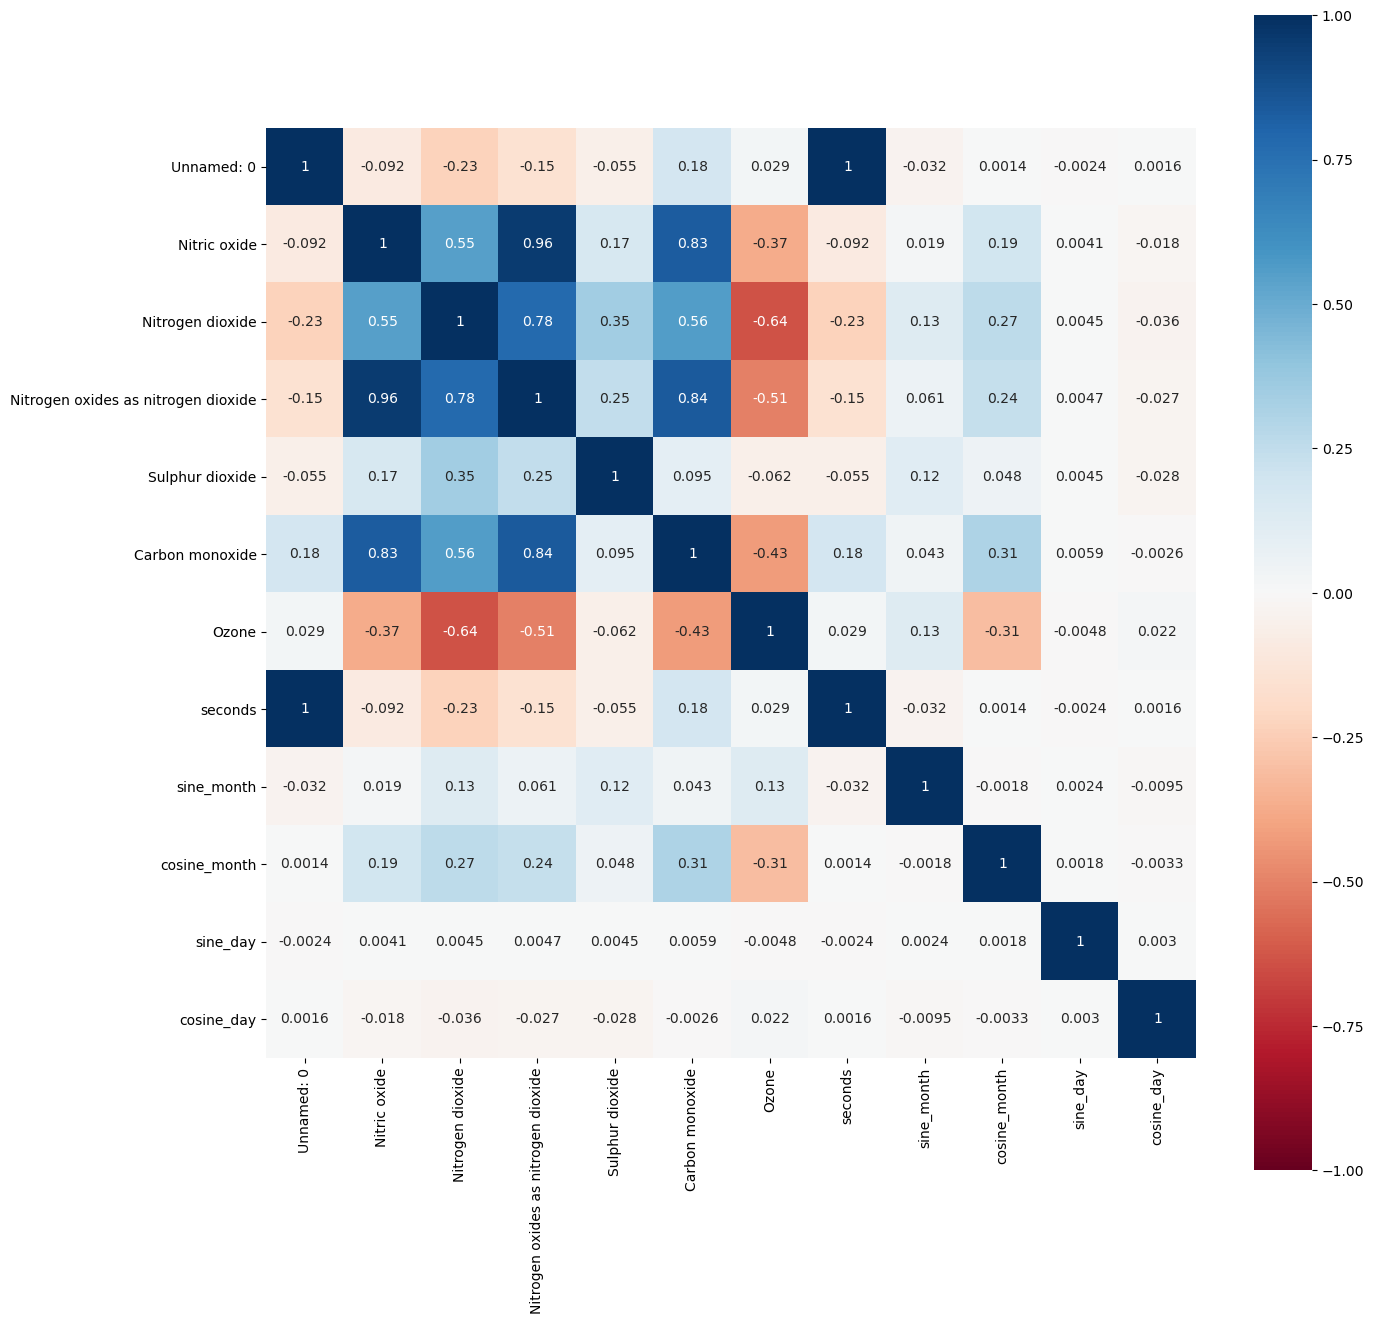

In [32]:
corrmat = df_port.drop(columns=["Date", "time"]).astype(float).corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots( figsize=(15, 15))
fig = sns.heatmap(corrmat, vmax=1, square=True, cmap="RdBu",  annot=True, vmin = -1);

plt.show()

Whilst the cosin and sin of the months correlate with some pollutans, no correlation is seen for the trigonometry of the days. We therefore drop these columns. 

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [34]:
df_scaled = df_port.copy().drop(columns=["Date", "time", "sine_day", "cosine_day"])

In [35]:
df_scaled[df_port.drop(columns=["Date", "time", "sine_day", "cosine_day"]).columns] = pd.DataFrame(scaler.fit_transform(df_scaled))

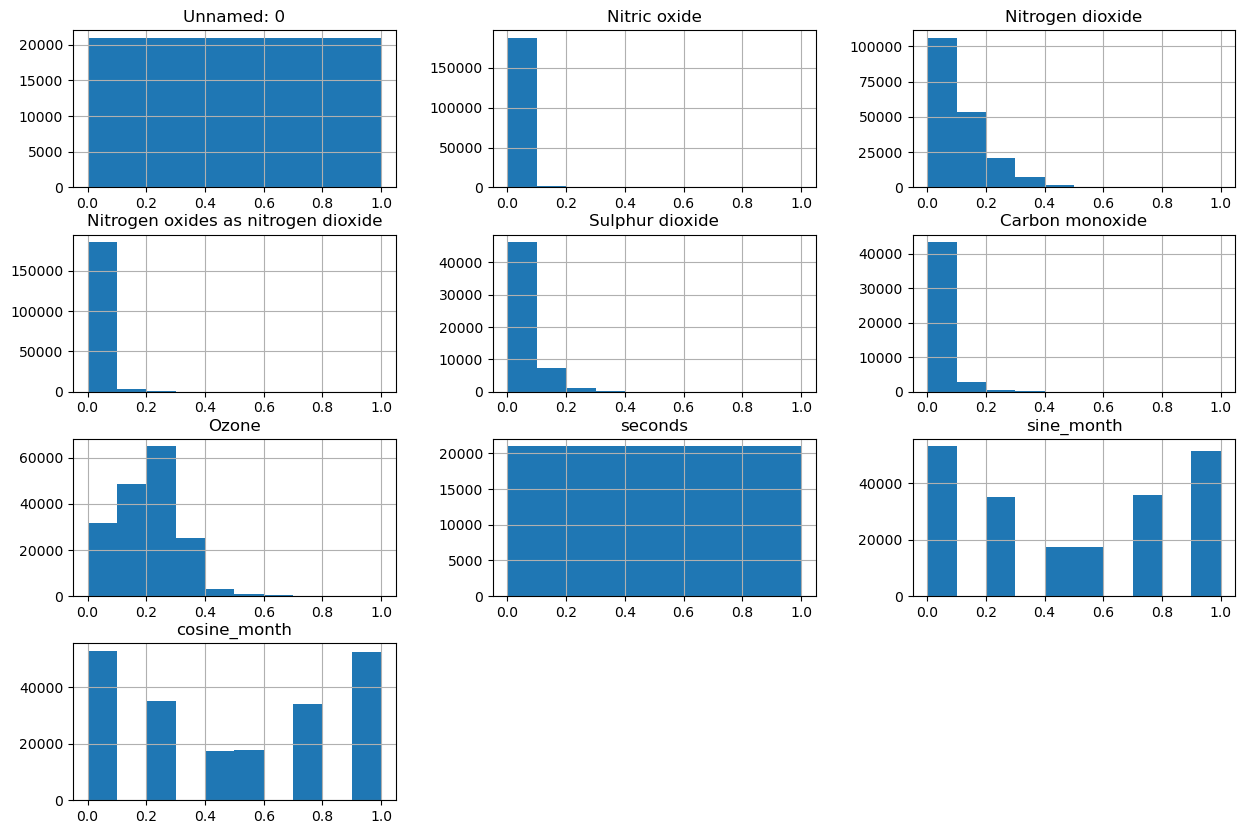

In [36]:
df_scaled.hist(bins=10, figsize=(15, 10))
plt.show()

In [37]:
df_scaled.head()

,Unnamed: 0,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,Ozone,seconds,sine_month,cosine_month
0,0.000000,0.001780,0.036944,0.006286,NaN,NaN,NaN,0.000000,0.75,0.933013
1,0.000005,0.000492,0.048142,0.006286,NaN,NaN,NaN,0.000005,0.75,0.933013
2,0.000010,0.000492,0.036944,0.004769,NaN,NaN,NaN,0.000010,0.75,0.933013
3,0.000014,0.000492,0.036944,0.004769,NaN,NaN,NaN,0.000014,0.75,0.933013
4,0.000019,0.000492,0.036944,0.004769,NaN,NaN,NaN,0.000019,0.75,0.933013


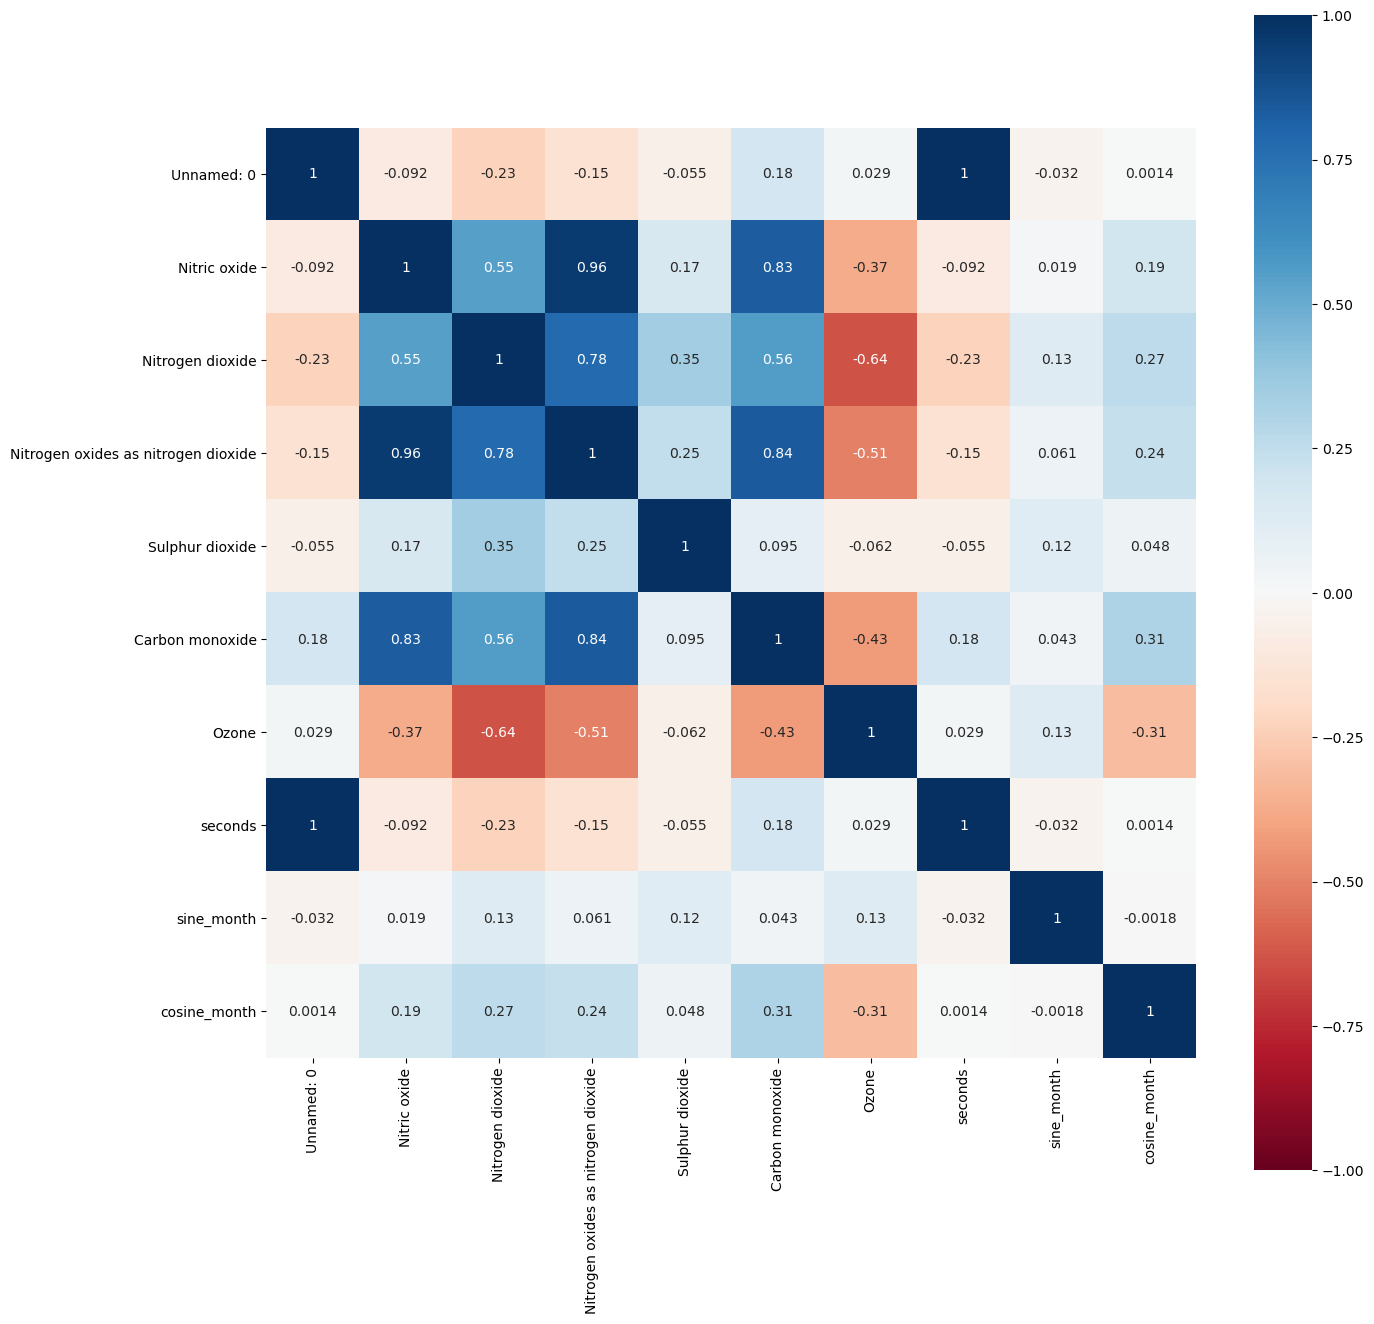

In [38]:
corrmat = df_scaled.astype(float).corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots( figsize=(15, 15))
fig = sns.heatmap(corrmat, vmax=1, vmin = -1, square=True, cmap="RdBu",  annot=True);

plt.show()

We can see how Sulphure dioxide has little to none correlaion with other pollutants, so we are expecting to forecast this pollutant will be more difficult than to predict the Carbon Monoxide, which shows higher correlations

In [39]:
df_port

,Unnamed: 0,Date,time,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,Ozone,seconds,sine_month,cosine_month,sine_day,cosine_day
0,0,2001-01-01,01:00,1.0,6.00000,8.00000,NaN,NaN,NaN,0.000000,5.000000e-01,0.866025,0.201299,0.979530
1,1,2001-01-01,02:00,0.0,8.00000,8.00000,NaN,NaN,NaN,0.000036,5.000000e-01,0.866025,0.201299,0.979530
2,2,2001-01-01,03:00,0.0,6.00000,6.00000,NaN,NaN,NaN,0.000072,5.000000e-01,0.866025,0.201299,0.979530
3,3,2001-01-01,04:00,0.0,6.00000,6.00000,NaN,NaN,NaN,0.000108,5.000000e-01,0.866025,0.201299,0.979530
4,4,2001-01-01,05:00,0.0,6.00000,6.00000,NaN,NaN,NaN,0.000144,5.000000e-01,0.866025,0.201299,0.979530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209731,209731,2024-12-04,20:00,0.0,7.07625,7.07625,NaN,NaN,70.64778,7.550316,-2.449294e-16,1.000000,0.724793,0.688967
209732,209732,2024-12-04,21:00,0.0,8.41500,8.41500,NaN,NaN,66.65638,7.550352,-2.449294e-16,1.000000,0.724793,0.688967
209733,209733,2024-12-04,22:00,0.0,7.26750,7.26750,NaN,NaN,60.46971,7.550388,-2.449294e-16,1.000000,0.724793,0.688967
209734,209734,2024-12-04,23:00,0.0,6.88500,6.88500,NaN,NaN,57.07702,7.550424,-2.449294e-16,1.000000,0.724793,0.688967


# FORECASTING WITH MACHINE LEARNING

We can see when we have data for Carbon Monoxide and Sulphur Dioxide

In [40]:
np.unique(df_port[df_port["Carbon monoxide"].notna()]["Date"].dt.year)

array([2002, 2003, 2004, 2005, 2006, 2007])

In [41]:
np.unique(df_port[df_port["Sulphur dioxide"].notna()]["Date"].dt.year)

array([2001, 2002, 2003, 2004, 2005, 2006, 2007])

Now, we construct the train and test dataset 

In [42]:
df_train_year = {}

for year in list(range(2002, 2006)):
    df_train_year[year] = df_scaled[df_port["Date"].dt.year == year]

In [43]:
dftrain_to_conc = []

for year in list(range(2002, 2006)):
    dftrain_to_conc.append(df_train_year[year])

In [44]:
df_train = pd.concat(dftrain_to_conc, ignore_index=True) 

In [45]:
# Dictionary to store DataFrames 
df_test_year = {}

for year in list(range(2006, 2008)):
    df_test_year[year] = df_scaled[df_port["Date"].dt.year == year]

dftest_to_conc = []

for year in list(range(2006, 2008)):
    dftest_to_conc.append(df_test_year[year])

df_test = pd.concat(dftest_to_conc, ignore_index=True) 

In [46]:
df_test, df_train = df_test.dropna(), df_train.dropna()

In [47]:
df_train['Sulphur dioxide']

11257    0.0625
11258    0.0625
11259    0.0625
11260    0.0625
11261    0.0625
          ...  
35059    0.0375
35060    0.0375
35061    0.0375
35062    0.0375
35063    0.0625
Name: Sulphur dioxide, Length: 20515, dtype: float64

## Let's predict Carbon Monoxide 

In [48]:
X_train = df_train.drop(columns=['Carbon monoxide', "Sulphur dioxide"])
y_train = df_train[['Carbon monoxide', "Sulphur dioxide"]]

X_test = df_test.drop(columns=['Carbon monoxide', "Sulphur dioxide"])
y_test = df_test[['Carbon monoxide', "Sulphur dioxide"]]

# Linear Regression

In [49]:
import sklearn

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [51]:
from sklearn import linear_model
model = linear_model.Ridge(alpha=.5)
model.fit(X_train, y_train)


Ridge(alpha=0.5)

In [52]:
y_pred = model.predict(X_test)

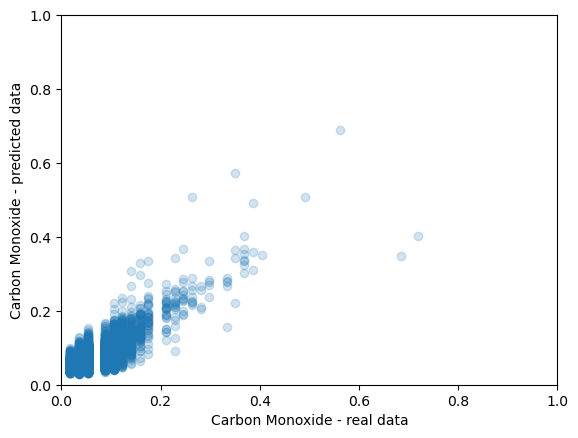

In [53]:
plt.scatter(y_test.iloc[:,0], y_pred[:,0], alpha=0.2)
plt.xlabel("Carbon Monoxide - real data")
plt.ylabel("Carbon Monoxide - predicted data")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

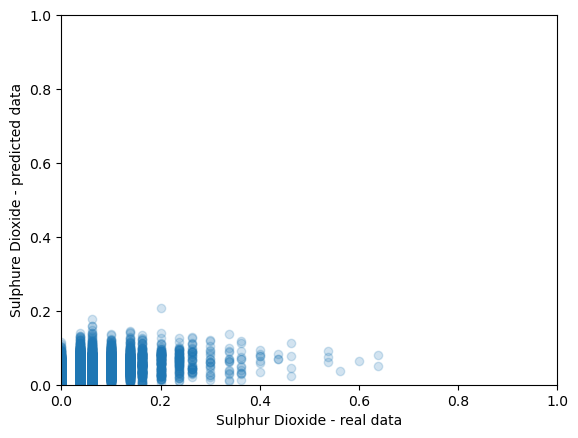

In [54]:
plt.scatter(y_test.iloc[:,1], y_pred[:,1], alpha=0.2)

plt.xlabel("Sulphur Dioxide - real data")
plt.ylabel("Sulphure Dioxide - predicted data")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [55]:
r2_score(y_test.iloc[:,0], y_pred[:,0]), r2_score(y_test.iloc[:,1], y_pred[:,1])


(0.4093973646756127, 0.1705695856982674)

### First Results:
With this simple model, the predictions for the Sulphur Dioxide has a r2 score blow 0.2 and we can appreciate how the predictions show an offset compared to the real value. On the other side, the Carbon Monoxide predictions are better, with a r2 score of around 0.4.

We can try with a more sophistiated model, e.g. the Gaussian Process Regressor 

# Gaussian Process Regressor

In [56]:
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C 
from sklearn.metrics import mean_squared_error 

In [57]:
# Define the kernel: RBF kernel with a constant kernel component (for flexibility) kernel 
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) 

In [58]:
# Initialize the Gaussian Process Regressor 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.01) 
# Fit the model 


In [59]:
gp.fit(X_train[::25], y_train[::25]) 

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [60]:
_pred, sigma = gp.predict(X_test, return_std=True) 

In [61]:
mse = mean_squared_error(y_test, y_pred) 
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0014024574922565569


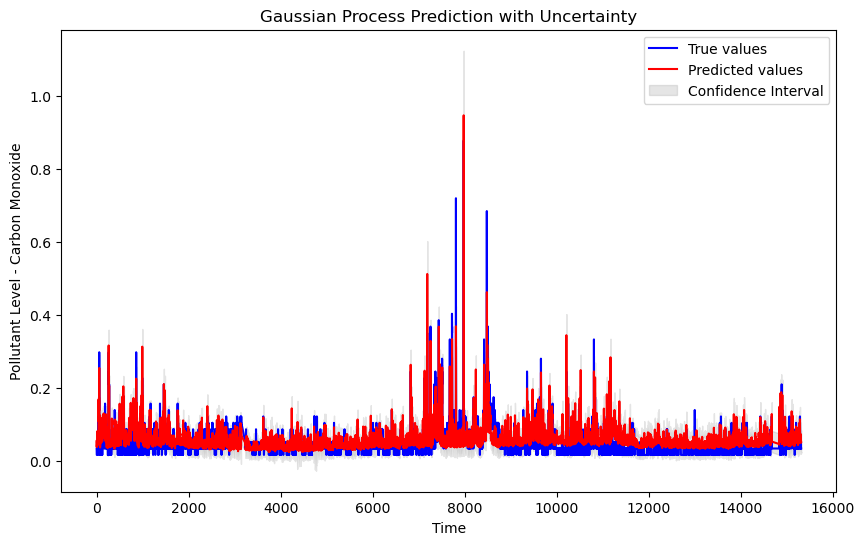

In [62]:
plt.figure(figsize=(10, 6)) 
plt.plot(df_test.index[:len(y_test)], y_test.iloc[:,0], 'b-', label='True values') 
plt.plot(df_test.index[:len(_pred)], _pred[:,0], 'r-', label='Predicted values') 
plt.fill_between(df_test.index[:len(_pred[:,0])], _pred[:,0] - 2 * sigma[:,0], _pred[:,0] + 2 * sigma[:,0],\
                 color='gray', alpha=0.2, label='Confidence Interval') 
plt.xlabel('Time') 
plt.ylabel('Pollutant Level - Carbon Monoxide') 
plt.title('Gaussian Process Prediction with Uncertainty') 
plt.legend() 
plt.show() 

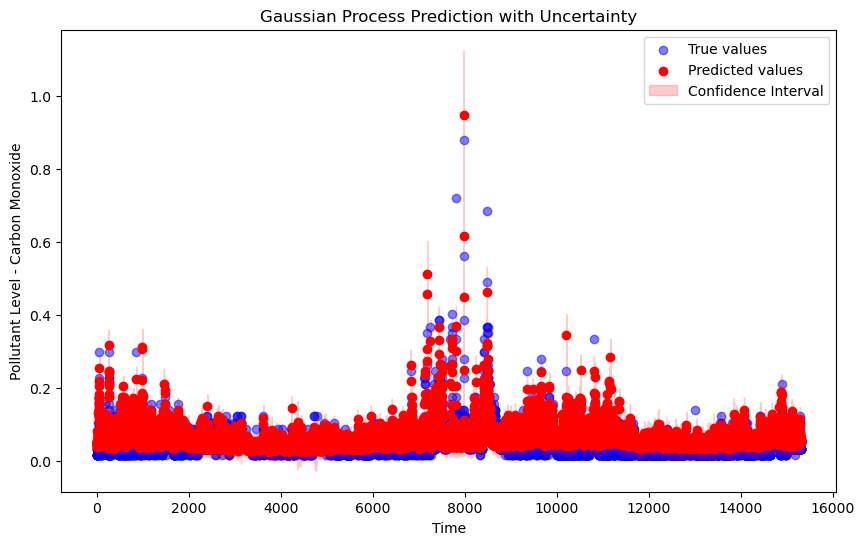

In [63]:
plt.figure(figsize=(10, 6)) 
plt.scatter(df_test.index[:len(y_test)], y_test.iloc[:,0], color='b', label='True values', alpha=0.5) 
plt.scatter(df_test.index[:len(_pred)], _pred[:,0], color='r', label='Predicted values') 
plt.fill_between(df_test.index[:len(_pred[:,0])], _pred[:,0] - 2 * sigma[:,0], _pred[:,0] + 2 * sigma[:,0], \
                 color='red', alpha=0.2, label='Confidence Interval') 
plt.xlabel('Time') 
plt.ylabel('Pollutant Level - Carbon Monoxide') 
plt.title('Gaussian Process Prediction with Uncertainty') 
plt.legend() 
plt.show() 

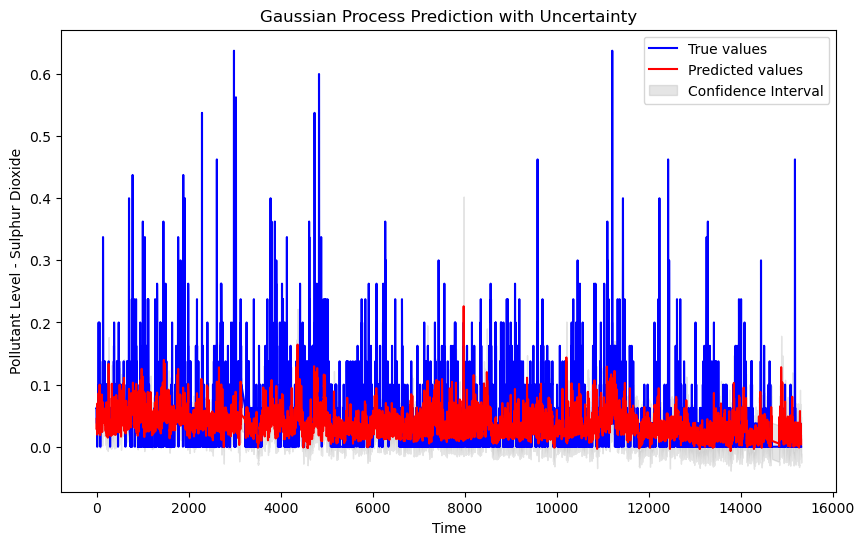

In [64]:
plt.figure(figsize=(10, 6)) 
plt.plot(df_test.index[:len(y_test)], y_test.iloc[:,1], 'b-', label='True values') 
plt.plot(df_test.index[:len(_pred)], _pred[:,1], 'r-', label='Predicted values') 
plt.fill_between(df_test.index[:len(_pred[:,1])], _pred[:,1] - 2 * sigma[:,1], _pred[:,1] + 2 * sigma[:,1],\
                 color='gray', alpha=0.2, label='Confidence Interval') 
plt.xlabel('Time') 
plt.ylabel('Pollutant Level - Sulphur Dioxide') 
plt.title('Gaussian Process Prediction with Uncertainty') 
plt.legend() 
plt.show() 

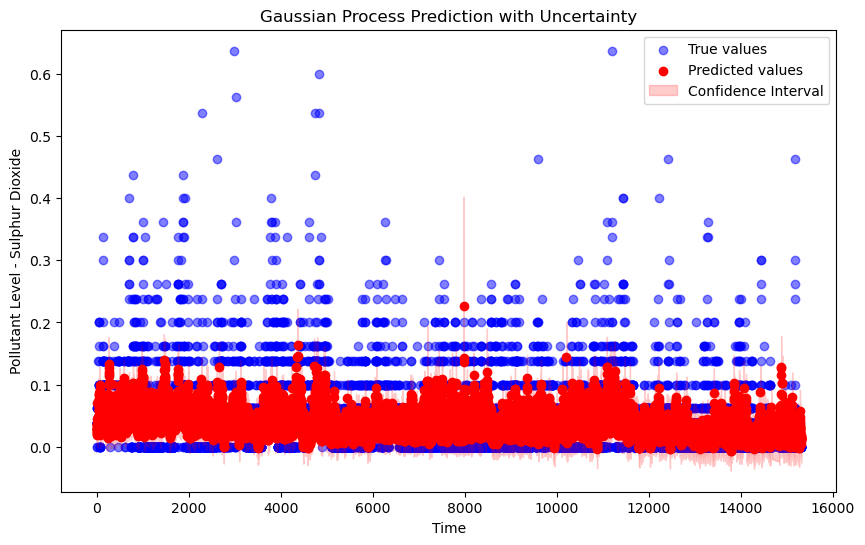

In [65]:
plt.figure(figsize=(10, 6)) 
plt.scatter(df_test.index[:len(y_test)], y_test.iloc[:,1], color='b', label='True values', alpha=0.5) 
plt.scatter(df_test.index[:len(_pred)], _pred[:,1], color='r', label='Predicted values') 
plt.fill_between(df_test.index[:len(_pred[:,1])], _pred[:,1] - 2 * sigma[:,1], _pred[:,1] + 2 * sigma[:,1], \
                 color='red', alpha=0.2, label='Confidence Interval') 
plt.xlabel('Time') 
plt.ylabel('Pollutant Level - Sulphur Dioxide') 
plt.title('Gaussian Process Prediction with Uncertainty') 
plt.legend() 
plt.show() 

Again, we are seeing how carbon Monoxide has better predictions than Sulphur Dioxide
If we look at the covariance matrix, we can notice how Sulphure Dioxide has little to none correlation with other chemicals

# Forecast

In [66]:
gp.fit(X_train[::25], y_train["Carbon monoxide"][::25]) 

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [67]:
# Dictionary to store DataFrames 
df_forecast_year = {}

for year in list(range(2008, 2025)):
    df_forecast_year[year] = df_scaled[df_port["Date"].dt.year == year]

dfforecast_to_conc = []

for year in list(range(2008, 2025)):
    dfforecast_to_conc.append(df_forecast_year[year])

df_fore = pd.concat(dfforecast_to_conc, ignore_index=True) 

In [68]:
X_fore = df_fore.drop(columns=['Carbon monoxide', "Sulphur dioxide"]).dropna()


In [69]:
_pred, sigma = gp.predict(X_fore, return_std=True) 

In [70]:
df_fore_pred = X_fore.copy()
df_fore_pred["Carbon monoxide"] = _pred

In [71]:
df_fore_pred["Sulphur dioxide"] = np.nan

In [72]:
df_fore_unscaled = df_fore_pred[df_scaled.columns].copy()

In [73]:
df_fore_unscaled[df_scaled.columns] = scaler.inverse_transform(df_fore_pred[df_scaled.columns])

In [74]:
df_fore_unscaled

,Unnamed: 0,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,Ozone,seconds,sine_month,cosine_month
0,61343.0,13.0,40.00000,59.00000,NaN,0.562153,26.00000,2.208348,5.000000e-01,0.866025
1,61344.0,1.0,27.00000,29.00000,NaN,0.427758,40.00000,2.208384,5.000000e-01,0.866025
2,61345.0,1.0,13.00000,15.00000,NaN,0.362900,52.00000,2.208420,5.000000e-01,0.866025
3,61346.0,8.0,52.00000,63.00000,NaN,0.586008,12.00000,2.208456,5.000000e-01,0.866025
4,61347.0,8.0,53.00000,65.00000,NaN,0.592832,6.00000,2.208492,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
148388,209731.0,0.0,7.07625,7.07625,NaN,1.161298,70.64778,7.550316,-2.220446e-16,1.000000
148389,209732.0,0.0,8.41500,8.41500,NaN,1.167359,66.65638,7.550352,-2.220446e-16,1.000000
148390,209733.0,0.0,7.26750,7.26750,NaN,1.162095,60.46971,7.550388,-2.220446e-16,1.000000
148391,209734.0,0.0,6.88500,6.88500,NaN,1.160332,57.07702,7.550424,-2.220446e-16,1.000000


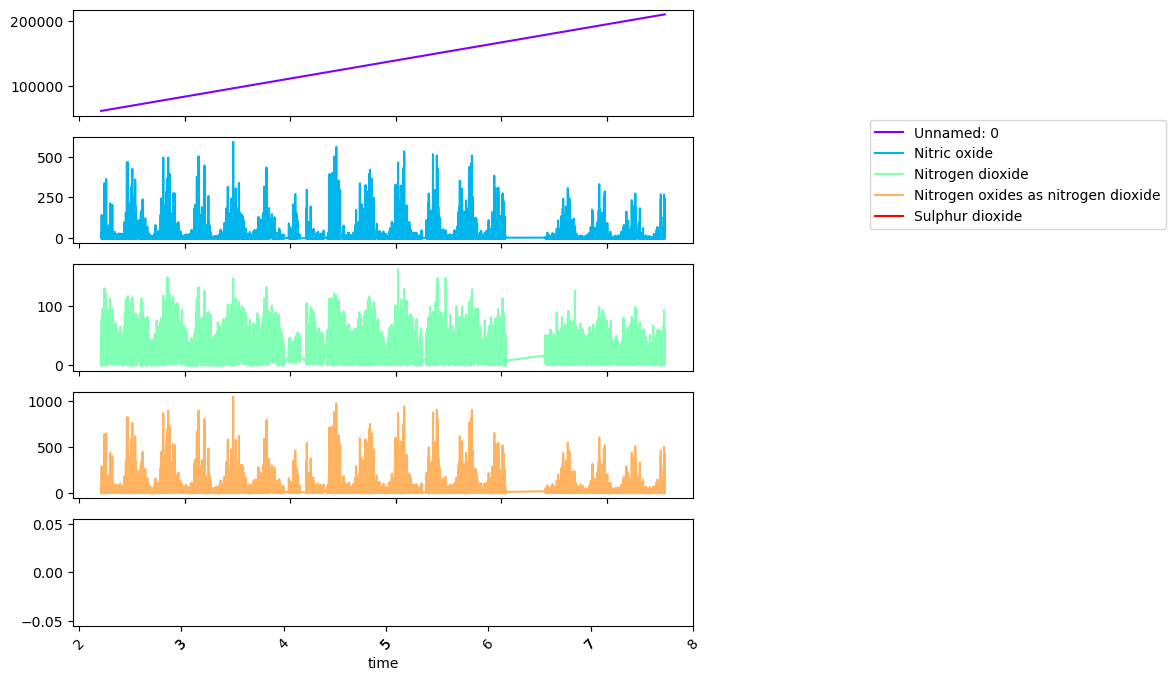

In [75]:
colors = cm.rainbow(np.linspace(0, 1, len(df_fore_unscaled.columns[0:5])))

fig, axes = plt.subplots(nrows=len(df_fore_unscaled.columns[0:5]),ncols=1, sharex=True, figsize=(8,8))

for i in range(len(df_fore_unscaled.columns[0:5])):
    axes[i].plot(df_fore_unscaled["seconds"], df_fore_unscaled[df_fore_unscaled.columns[i]].astype(float), label=str(df_fore_unscaled.columns[i]),\
                color=colors[i])
    xmin, xmax = axes[i].get_xlim()
    N=10
    axes[i].set_xticks(np.round(np.linspace(xmin, xmax, N)))


    axes[i].xaxis.set_tick_params(rotation=45)
fig.legend(bbox_to_anchor=(1.5, .75))
plt.xlabel("time")


plt.show()


We can see how it is predicted as a cycle + over all increase in time

# XGBOOST

In [76]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

/home/nannil/anaconda3/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [77]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train.values, y_train["Carbon monoxide"].values,
        eval_set=[(X_train.values, y_train["Carbon monoxide"].values), (X_test.values, y_test["Carbon monoxide"].values)],
       verbose=False) #

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [78]:
X_train.columns

Index(['Unnamed: 0', 'Nitric oxide', 'Nitrogen dioxide',
       'Nitrogen oxides as nitrogen dioxide', 'Ozone', 'seconds', 'sine_month',
       'cosine_month'],
      dtype='object')

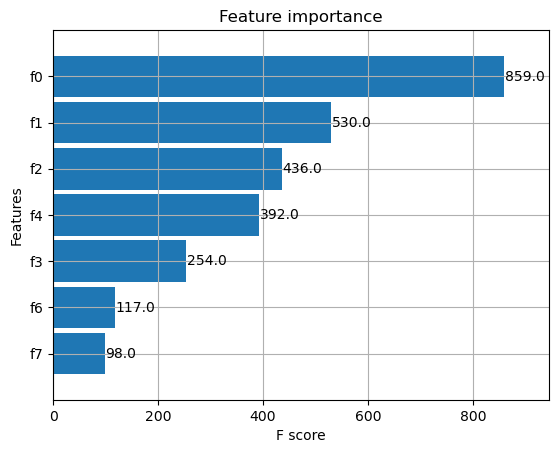

In [79]:
_ = plot_importance(reg, height=0.9)
plt.show()

In [80]:
y_pred = reg.predict(X_test.values)


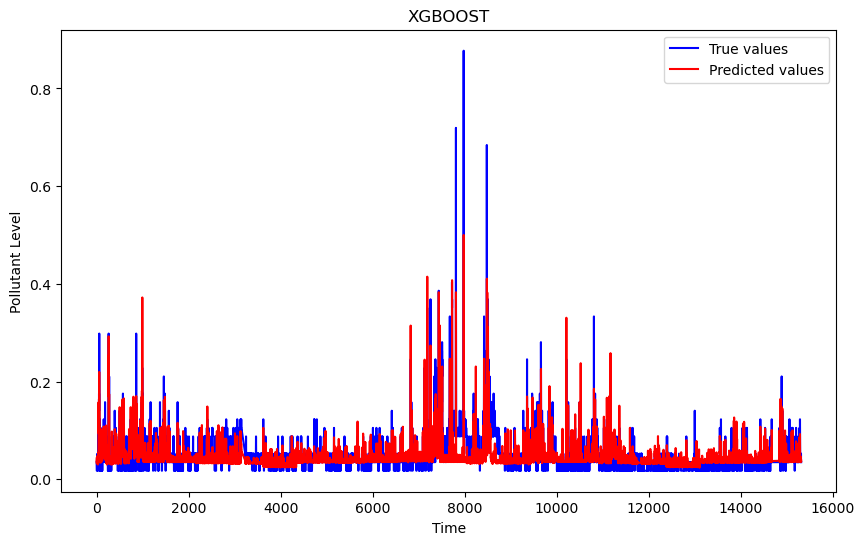

In [81]:
plt.figure(figsize=(10, 6)) 
plt.plot(df_test.index[:len(y_test)], y_test["Carbon monoxide"], 'b-', label='True values') 
plt.plot(df_test.index[:len(y_pred)], y_pred, 'r-', label='Predicted values') 
plt.xlabel('Time') 
plt.ylabel('Pollutant Level') 
plt.title('XGBOOST') 
plt.legend() 
plt.show() 

In [82]:
y_pred_fore = reg.predict(X_fore.values)


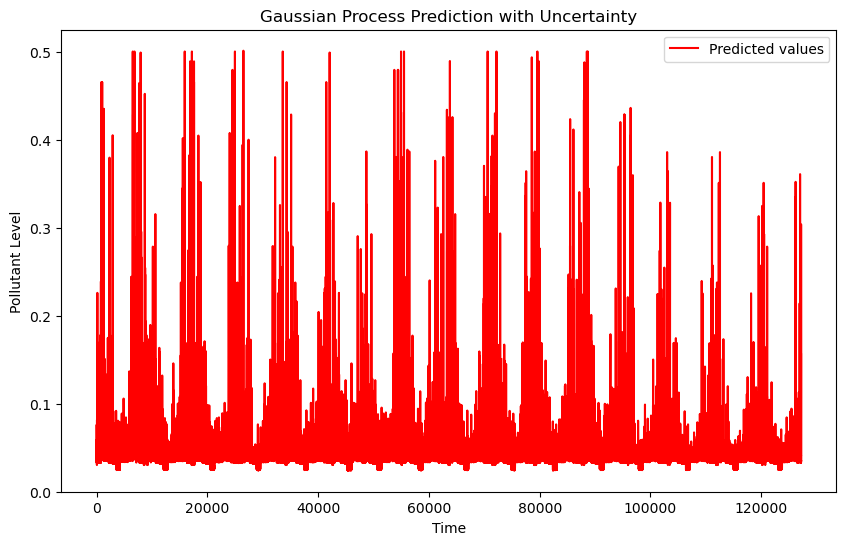

In [83]:
plt.figure(figsize=(10, 6)) 

plt.plot(df_fore.index[:len(_pred)], y_pred_fore, color='r', label='Predicted values') 

plt.xlabel('Time') 
plt.ylabel('Pollutant Level') 
plt.title('Gaussian Process Prediction with Uncertainty') 
plt.legend() 
plt.show() 

In [84]:
df_fore_pred = X_fore.copy()
df_fore_pred["Carbon monoxide"] = y_pred_fore

df_fore_pred["Sulphur dioxide"] = np.nan

df_fore_unscaled = df_fore_pred[df_scaled.columns].copy()

df_fore_unscaled[df_scaled.columns] = scaler.inverse_transform(df_fore_pred[df_scaled.columns])

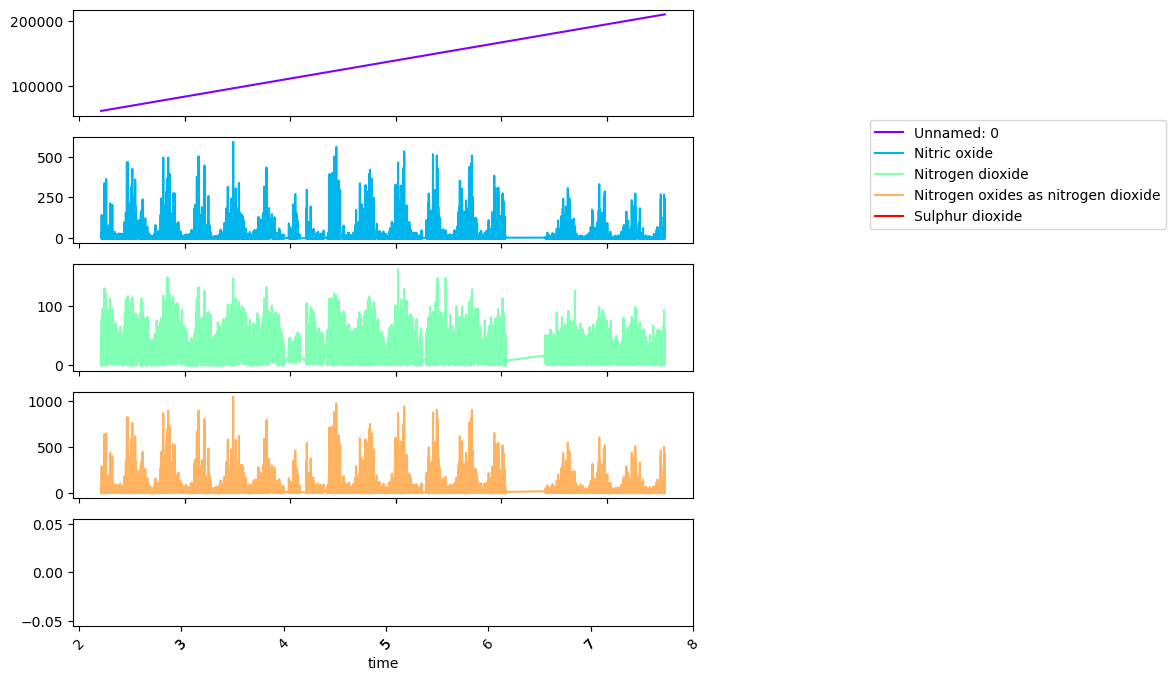

In [85]:
colors = cm.rainbow(np.linspace(0, 1, len(df_fore_unscaled.columns[0:5])))

fig, axes = plt.subplots(nrows=len(df_fore_unscaled.columns[0:5]),ncols=1, sharex=True, figsize=(8,8))

for i in range(len(df_fore_unscaled.columns[0:5])):
    axes[i].plot(df_fore_unscaled["seconds"], df_fore_unscaled[df_fore_unscaled.columns[i]].astype(float), label=str(df_fore_unscaled.columns[i]),\
                color=colors[i])
    xmin, xmax = axes[i].get_xlim()
    N=10
    axes[i].set_xticks(np.round(np.linspace(xmin, xmax, N)))


    axes[i].xaxis.set_tick_params(rotation=45)
fig.legend(bbox_to_anchor=(1.5, .75))
plt.xlabel("time")


plt.show()


# LSTM

In [86]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM


In [87]:
model = Sequential()
model.add(LSTM(256,input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [88]:
history = model.fit(x=X_train,y=y_train,epochs=50,validation_data=(X_test,y_test), shuffle=False)

Epoch 1/50
642/642 [==============================] - 19s 26ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 2/50
642/642 [==============================] - 16s 26ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 3/50
642/642 [==============================] - 16s 26ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 4/50
642/642 [==============================] - 16s 26ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 5/50
642/642 [==============================] - 17s 27ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/50
642/642 [==============================] - 17s 27ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/50
642/642 [==============================] - 17s 27ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/50
642/642 [==============================] - 17s 27ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/50
642/642 [==============================] - 17s 27ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/50
642/642 [==============================] - 16s 26ms/step - loss: 0.001

In [89]:
Y_predicted = model.predict(X_test)


464/464 [==============================] - 4s 8ms/step


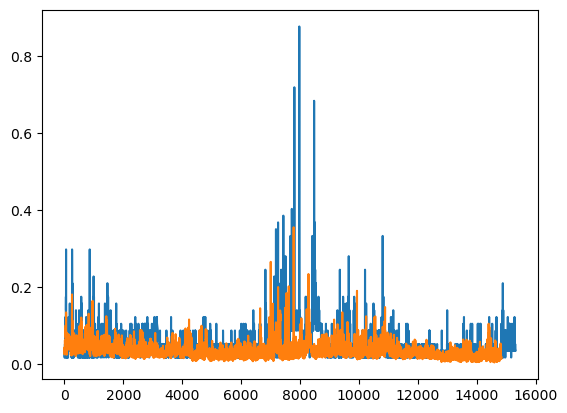

In [90]:
plt.plot(y_test["Carbon monoxide"], label='True Y')
plt.plot(Y_predicted[:,0], label='Predicted Y')
plt.show()

3976/3976 [==============================] - 31s 8ms/step


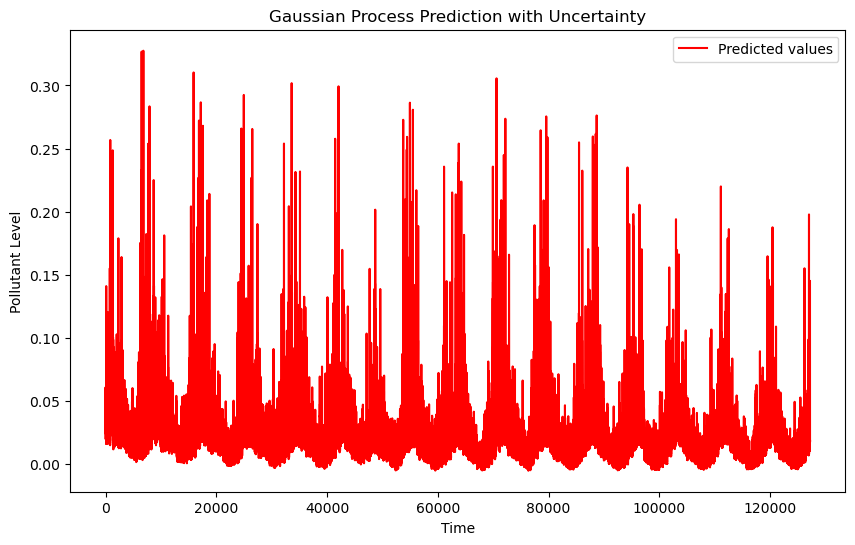

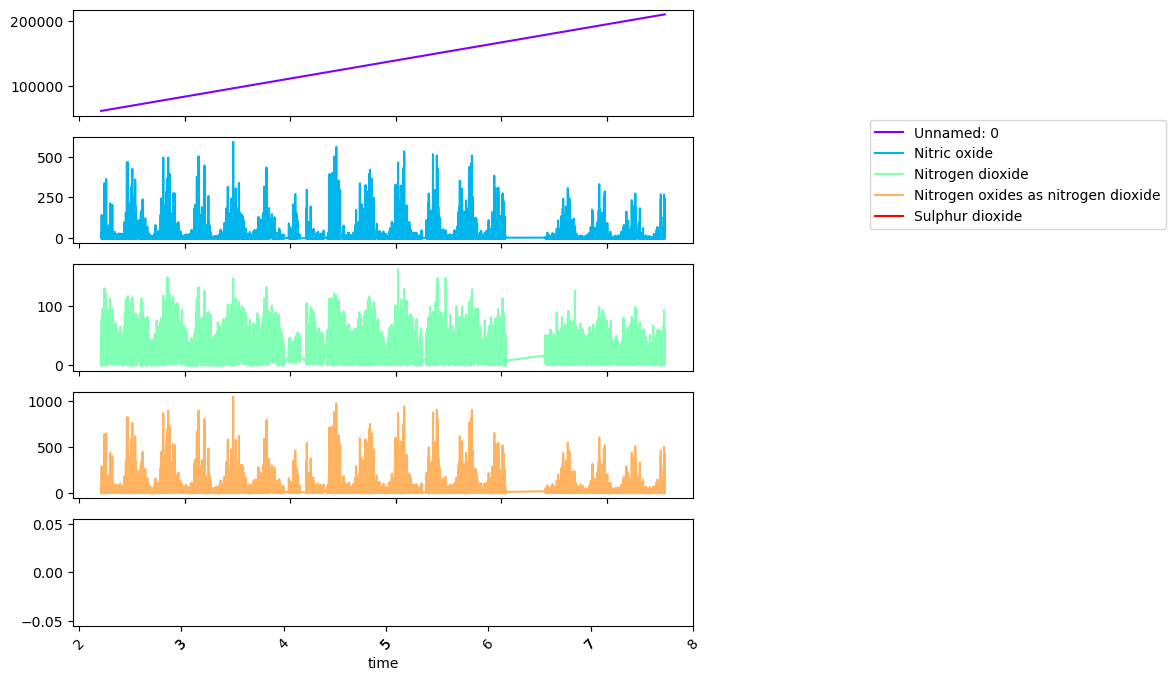

In [91]:
y_pred_fore = model.predict(X_fore.values)


plt.figure(figsize=(10, 6)) 

plt.plot(df_fore.index[:len(_pred)], y_pred_fore, color='r', label='Predicted values') 

plt.xlabel('Time') 
plt.ylabel('Pollutant Level') 
plt.title('Gaussian Process Prediction with Uncertainty') 
plt.legend() 
plt.show() 

df_fore_pred = X_fore.copy()
df_fore_pred["Carbon monoxide"] = y_pred_fore

df_fore_pred["Sulphur dioxide"] = np.nan

df_fore_unscaled = df_fore_pred[df_scaled.columns].copy()

df_fore_unscaled[df_scaled.columns] = scaler.inverse_transform(df_fore_pred[df_scaled.columns])

colors = cm.rainbow(np.linspace(0, 1, len(df_fore_unscaled.columns[0:5])))

fig, axes = plt.subplots(nrows=len(df_fore_unscaled.columns[0:5]),ncols=1, sharex=True, figsize=(8,8))

for i in range(len(df_fore_unscaled.columns[0:5])):
    axes[i].plot(df_fore_unscaled["seconds"], df_fore_unscaled[df_fore_unscaled.columns[i]].astype(float), label=str(df_fore_unscaled.columns[i]),\
                color=colors[i])
    xmin, xmax = axes[i].get_xlim()
    N=10
    axes[i].set_xticks(np.round(np.linspace(xmin, xmax, N)))


    axes[i].xaxis.set_tick_params(rotation=45)
fig.legend(bbox_to_anchor=(1.5, .75))
plt.xlabel("time")


plt.show()
